<a href="https://colab.research.google.com/github/kosmasrio0411/game-toxic-detection/blob/main/SlotGatedRNN_CONDA_Augmented_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
import os
import random
import json
import csv
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm
from gensim.models import Word2Vec
from dataclasses import dataclass
from typing import List

In [ ]:
# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
train_csv = 'CONDA_train_leaderboard.csv'
val_csv   = 'CONDA_valid_leaderboard.csv'
test_csv  = 'CONDA_test_leaderboard.csv'
save_dir  = 'outputs'
epochs    = 10
batch_size= 32
emb_dim   = 200
hidden    = 128
dropout   = 0.4
lr        = 1e-3
weight_decay = 1e-3
seed      = 13

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
os.makedirs(save_dir, exist_ok=True)
sns.set(style="whitegrid")

Device: cuda


In [ ]:
# Download NLTK for Augmentation
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Downloading WordNet data...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')

def set_seed(seed: int = 13):
    os.environ['PYTHONHASHSEED'] = str(seed) # Kunci hashing Python
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(seed)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# ==========================================
# 2. DATASET CLASSES
# ==========================================
@dataclass
class Example:
    idx: str
    tokens: List[str]
    intent: str
    slot_labels: List[str]

class CondaCsvDataset(Dataset):
    def __init__(self, path: str, has_labels: bool = True):
        self.examples: List[Example] = []
        if not os.path.exists(path):
            print(f"Warning: File {path} not found. Returning empty dataset.")
            return

        with open(path, newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                idx = row.get("Id", "0").strip()
                tokens = [t for t in row["tokenized"].strip().split() if t != ""]
                if has_labels:
                    intent = row["intentClass"].strip()
                    slot_labels = [s for s in row["slotClasses"].strip().split() if s != ""]
                    if len(tokens) != len(slot_labels): continue
                else:
                    intent = "O"
                    slot_labels = ["O"] * len(tokens)
                self.examples.append(Example(idx=idx, tokens=tokens, intent=intent, slot_labels=slot_labels))
    def __len__(self): return len(self.examples)
    def __getitem__(self, i): return self.examples[i]

class Vocab:
    def __init__(self, tokens: List[List[str]], w2v_model=None, min_freq: int = 1):
        from collections import Counter
        cnt = Counter()
        for seq in tokens: cnt.update(seq)
        self.itos = ["<pad>", "<unk>"]
        for tok, c in cnt.most_common():
            if c >= min_freq and tok not in {"<pad>","<unk>"}:
                self.itos.append(tok)
        self.stoi = {s:i for i,s in enumerate(self.itos)}

        self.embedding_matrix = None
        if w2v_model:
            emb_dim = w2v_model.vector_size
            self.embedding_matrix = torch.zeros(len(self), emb_dim)
            for i, word in enumerate(self.itos):
                if word in w2v_model.wv:
                    self.embedding_matrix[i] = torch.tensor(w2v_model.wv[word])
                elif word == '<unk>':
                     self.embedding_matrix[i] = torch.randn(emb_dim) * 0.1

    def __len__(self): return len(self.itos)
    def encode(self, seq: List[str]):
        unk = self.stoi.get("<unk>", 1)
        return [self.stoi.get(t, unk) for t in seq]

class LabelMap:
    def __init__(self, labels: List[str], add_pad: bool=False):
        uniq = sorted(set(labels))
        self.itos = ["<pad>"] + uniq if add_pad else uniq
        self.stoi = {s:i for i,s in enumerate(self.itos)}
    def __len__(self): return len(self.itos)

In [ ]:
# ==========================================
# 3. AUGMENTATION & EDA FUNCTIONS
# ==========================================
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if "_" not in lemma.name() and lemma.name().lower() != word.lower():
                synonyms.add(lemma.name().lower())
    return sorted(list(synonyms))

def augment_dataset(dataset, target_intents, target_slots, num_aug=1, alpha_sr=0.1):
    set_seed(13)
    print(f"Augmenting data... (Original: {len(dataset.examples)})")
    augmented_data = []

    for ex in dataset.examples:
        # Check targets
        is_target_intent = ex.intent in target_intents
        has_target_slot = any(s in target_slots for s in ex.slot_labels)

        if is_target_intent or has_target_slot:
            # Cari kandidat token 'O' untuk diganti
            candidates = [i for i, (t, s) in enumerate(zip(ex.tokens, ex.slot_labels)) if s == 'O']
            if not candidates: continue

            for n in range(num_aug):
                new_tokens = ex.tokens.copy()
                num_replace = max(1, int(len(candidates) * alpha_sr))
                replace_indices = random.sample(candidates, min(len(candidates), num_replace))

                changed = False
                for i in replace_indices:
                    syns = get_synonyms(new_tokens[i])
                    if syns:
                        new_tokens[i] = random.choice(syns)
                        changed = True

                if changed:
                    new_ex = copy.deepcopy(ex)
                    new_ex.idx = f"{ex.idx}_aug_{n}"
                    new_ex.tokens = new_tokens
                    augmented_data.append(new_ex)

    dataset.examples.extend(augmented_data)
    print(f"Augmentation Done. New Size: {len(dataset.examples)} (+{len(augmented_data)})")

def run_eda(dataset, title="Dataset"):
    intents = [ex.intent for ex in dataset.examples]
    all_slots = [s for ex in dataset.examples for s in ex.slot_labels]

    plt.figure(figsize=(14, 5))

    # Intent Plot
    plt.subplot(1, 2, 1)
    if len(intents) > 0:
        sns.countplot(x=intents, order=pd.Series(intents).value_counts().index, palette="viridis")
    plt.title(f'Intent Dist. ({title})')
    plt.xlabel('Intent')
    plt.ylabel('Count')

    # Slot Plot (Exclude O and Pad)
    slots_no_o = [s for s in all_slots if s != 'O' and s != '<pad>']
    plt.subplot(1, 2, 2)
    if len(slots_no_o) > 0:
        sns.countplot(y=slots_no_o, order=pd.Series(slots_no_o).value_counts().index, palette="magma")
    plt.title(f'Slot Dist. (Non-O) ({title})')
    plt.xlabel('Count')

    plt.tight_layout()
    plt.show()

In [ ]:
# ==========================================
# 4. MODEL ARCHITECTURE
# ==========================================
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden: int, dropout: float, padding_idx: int, embedding_matrix=None):
        super().__init__()
        if embedding_matrix is not None:
            self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=padding_idx)
            emb_dim = embedding_matrix.shape[1]
        else:
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(emb_dim, hidden // 2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        emb = self.dropout(self.emb(x))
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(out, batch_first=True)
        out = self.dropout(out)
        return out

class AdditiveAttention(nn.Module):
    def __init__(self, hidden: int):
        super().__init__()
        self.Wk = nn.Linear(hidden, hidden, bias=False)
        self.Wq = nn.Linear(hidden, hidden, bias=False)
        self.v  = nn.Linear(hidden, 1, bias=False)

    def forward(self, keys, mask, query=None):
        K = self.Wk(keys)
        if query is None:
            e = self.v(torch.tanh(K)).masked_fill(~mask.unsqueeze(-1), -1e9)
            alpha = torch.softmax(e, dim=1)
            ctx = (alpha * keys).sum(dim=1)
            return ctx, alpha.squeeze(-1)
        else:
            Q = self.Wq(query)
            e = self.v(torch.tanh(K.unsqueeze(1) + Q.unsqueeze(2))).squeeze(-1)
            e = e.masked_fill(~mask.unsqueeze(1), -1e9)
            alpha = torch.softmax(e, dim=-1)
            ctx = torch.bmm(alpha, keys)
            return ctx, alpha

class SlotGatedJointNLU(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden, num_slots, num_intents, dropout, padding_idx=0, embedding_matrix=None):
        super().__init__()
        self.encoder = BiLSTMEncoder(vocab_size, emb_dim, hidden, dropout, padding_idx, embedding_matrix)
        self.slot_attn = AdditiveAttention(hidden)
        self.intent_attn = AdditiveAttention(hidden)
        self.W_g = nn.Linear(hidden, hidden, bias=False)
        self.v_g = nn.Linear(hidden, 1, bias=False)
        self.slot_out = nn.Linear(hidden * 2, num_slots)
        self.intent_out = nn.Linear(hidden, num_intents)

    def forward(self, x, lengths, mask):
        H = self.encoder(x, lengths)

        # Intent Context
        c_I, _ = self.intent_attn(H, mask)

        # Last Hidden State for Intent
        B, T, Hdim = H.shape
        idx = (lengths - 1).clamp(min=0).view(B, 1, 1).expand(B, 1, Hdim)
        h_T = H.gather(1, idx).squeeze(1)

        # Intent Logits
        intent_logits = self.intent_out(h_T + c_I)

        # Slot Context & Gating
        c_S, _ = self.slot_attn(H, mask, query=H)
        WcI = self.W_g(c_I)
        g = self.v_g(torch.tanh(c_S + WcI.unsqueeze(1))).squeeze(-1)
        gated_ctx = c_S * g.unsqueeze(-1)

        # Slot Logits
        slot_logits = self.slot_out(torch.cat([H, gated_ctx], dim=-1))

        return slot_logits, intent_logits

In [ ]:
# ==========================================
# 5. TRAINING HELPERS
# ==========================================
def pad_batch(batch, vocab, intent_map, slot_map, device):
    lens = [len(ex.tokens) for ex in batch]
    T = max(lens)
    x = torch.zeros(len(batch), T, dtype=torch.long)
    y_slots = torch.zeros(len(batch), T, dtype=torch.long)
    mask = torch.zeros(len(batch), T, dtype=torch.bool)
    y_int = torch.zeros(len(batch), dtype=torch.long)

    for i, ex in enumerate(batch):
        ids = vocab.encode(ex.tokens)
        L = len(ids)
        x[i, :L] = torch.tensor(ids)
        y_slots[i, :L] = torch.tensor([slot_map.stoi[s] for s in ex.slot_labels])
        mask[i, :L] = True
        y_int[i] = intent_map.stoi[ex.intent]

    return x.to(device), torch.tensor(lens).to(device), mask.to(device), y_slots.to(device), y_int.to(device)

def compute_jsa(intent_gold, intent_pred, slots_gold, slots_pred):
    correct = 0
    for ig, ip, sg, sp in zip(intent_gold, intent_pred, slots_gold, slots_pred):
        if ig == ip and len(sg) == len(sp) and all(a == b for a, b in zip(sg, sp)):
            correct += 1
    return correct / max(1, len(intent_gold))

def f1_binary(tp, fp, fn):
    return 2*tp/(2*tp+fp+fn) if (2*tp+fp+fn) > 0 else 0.0

def evaluate(model, loader, intent_map, slot_map, slot_loss_fn, intent_loss_fn):
    model.eval()
    intent_gold, intent_pred = [], []
    slots_gold, slots_pred = [], []
    total_slot, total_int, steps = 0.0, 0.0, 0

    # Loop tanpa tqdm biar log bersih
    for x, lens, mask, y_slots, y_int in loader:
        slot_logits, intent_logits = model(x, lens, mask)

        B, T, C = slot_logits.shape
        loss_slots = slot_loss_fn(slot_logits.view(B*T, C), y_slots.view(B*T))
        loss_int = intent_loss_fn(intent_logits, y_int)
        total_slot += loss_slots.item()
        total_int += loss_int.item()
        steps += 1

        ip = intent_logits.argmax(-1).tolist()
        intent_pred.extend([intent_map.itos[i] for i in ip])
        intent_gold.extend([intent_map.itos[i.item()] for i in y_int])

        sp = slot_logits.argmax(-1).tolist()
        for i, L in enumerate(lens.tolist()):
            slots_pred.append([slot_map.itos[j] for j in sp[i][:L]])
            slots_gold.append([slot_map.itos[j.item()] for j in y_slots[i][:L]])

    jsa = compute_jsa(intent_gold, intent_pred, slots_gold, slots_pred)

    # --- UPDATE: Hitung F1 Lengkap ---
    res = {}

    # 1. F1 Intent (E & I)
    for lab in ["E", "I"]:
        tp = sum(1 for g, p in zip(intent_gold, intent_pred) if g==lab and p==lab)
        fp = sum(1 for g, p in zip(intent_gold, intent_pred) if g!=lab and p==lab)
        fn = sum(1 for g, p in zip(intent_gold, intent_pred) if g==lab and p!=lab)
        res[f"f1_intent_{lab}"] = f1_binary(tp, fp, fn)

    # 2. F1 Slot (T, D, S)
    for lab in ["T", "D", "S"]:
        tp=fp=fn=0
        for sg, sp in zip(slots_gold, slots_pred):
            for a,b in zip(sg, sp):
                if b == lab and a == lab: tp += 1
                elif b == lab and a != lab: fp += 1
                elif a == lab and b != lab: fn += 1
        res[f"f1_slot_{lab}"] = f1_binary(tp, fp, fn)

    return jsa, res, total_slot/steps, total_int/steps, intent_gold, intent_pred, slots_gold, slots_pred

In [ ]:
# ==========================================
# 6. MAIN PIPELINE
# ==========================================

# A. LOAD DATA
print("1. Loading Data...")
train_ds = CondaCsvDataset(train_csv, has_labels=True)
val_ds   = CondaCsvDataset(val_csv, has_labels=True)

1. Loading Data...


In [ ]:
import pandas as pd


2. EDA BEFORE Augmentation...


/tmp/ipython-input-3997005417.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=intents, order=pd.Series(intents).value_counts().index, palette="viridis")
/tmp/ipython-input-3997005417.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=slots_no_o, order=pd.Series(slots_no_o).value_counts().index, palette="magma")


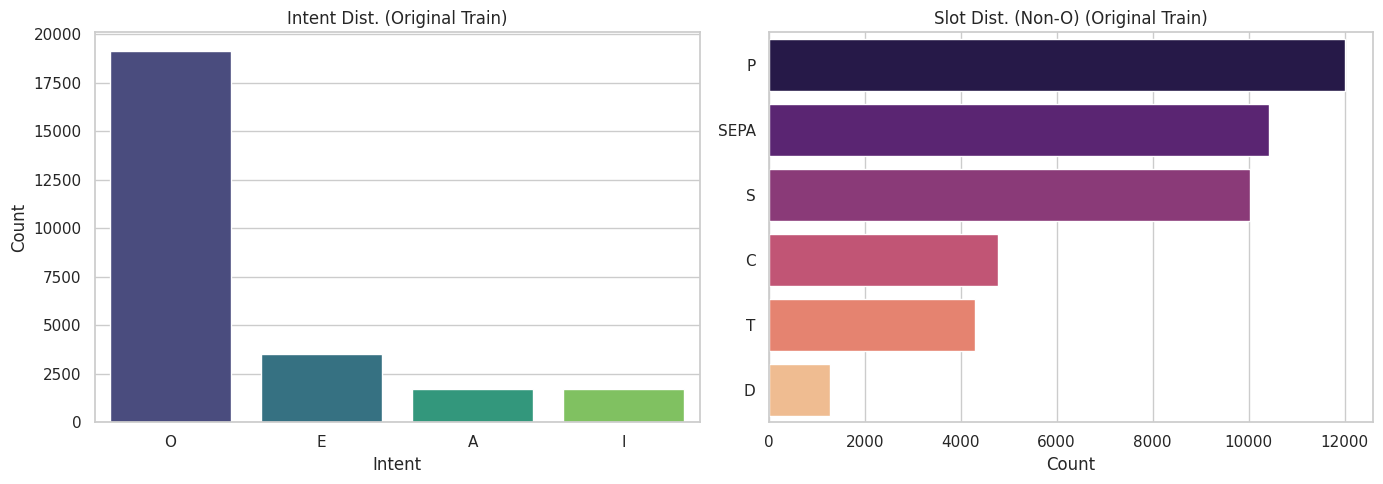

In [ ]:
# B. EDA SEBELUM AUGMENTASI
print("\n2. EDA BEFORE Augmentation...")
run_eda(train_ds, "Original Train")


3. Running Augmentation...
Augmenting data... (Original: 26086)
Augmentation Done. New Size: 31733 (+5647)

4. EDA AFTER Augmentation...


/tmp/ipython-input-3997005417.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=intents, order=pd.Series(intents).value_counts().index, palette="viridis")
/tmp/ipython-input-3997005417.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=slots_no_o, order=pd.Series(slots_no_o).value_counts().index, palette="magma")


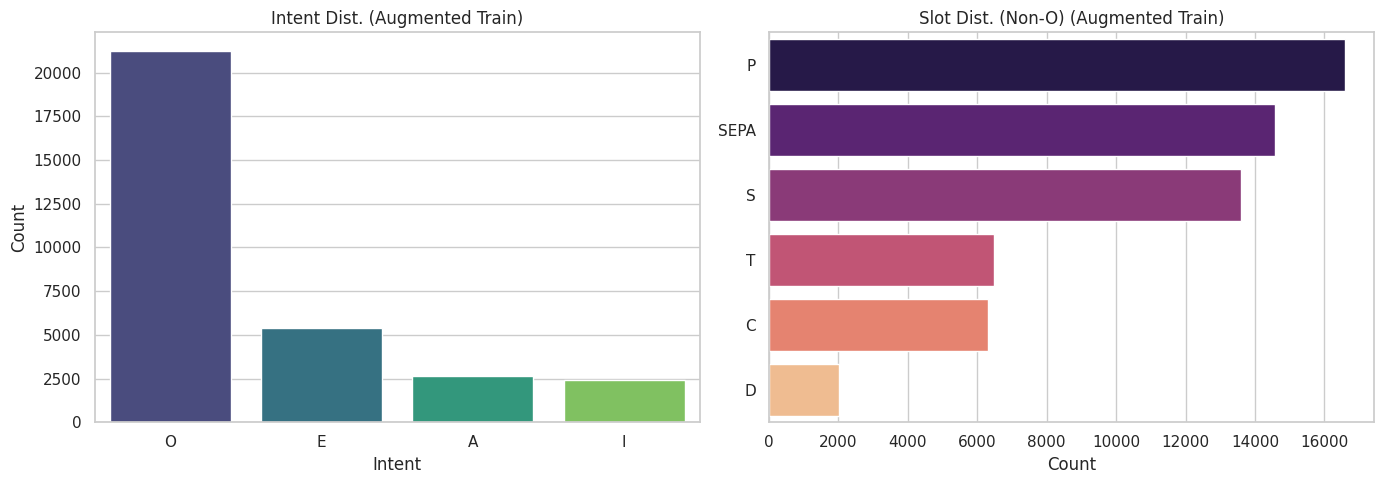

In [ ]:
# C. AUGMENTATION
print("\n3. Running Augmentation...")
# Target: Intent E/I/A dan Slot T/D/S
augment_dataset(train_ds,
                target_intents=['E','I','A'],
                target_slots=['T','D','S'],
                num_aug=1,
                alpha_sr=0.1)

# D. EDA SESUDAH AUGMENTASI
print("\n4. EDA AFTER Augmentation...")
run_eda(train_ds, "Augmented Train")

In [ ]:
# E. BUILD RESOURCES (Vocab & Weights)
print("\n5. Building Vocab & Weights...")

# 1. Vocab & Word2Vec
# Hapus file lama jika ada (opsional, cuma buat bersih-bersih disk)
if os.path.exists("dota2_word2vec_conda.model"):
    os.remove("dota2_word2vec_conda.model")
    print("File model lama dihapus.")

all_tokens = [ex.tokens for ex in train_ds.examples] + [ex.tokens for ex in val_ds.examples]
print("Training Word2Vec (FRESH)...")
w2v = Word2Vec(all_tokens, vector_size=emb_dim, window=5, min_count=1, workers=1, seed=seed)
w2v.save("dota2_word2vec_conda.model")

vocab = Vocab(all_tokens, w2v_model=w2v)
print(f"Vocab Size: {len(vocab)}")

# 2. Label Maps
intent_map = LabelMap([ex.intent for ex in train_ds.examples])
all_slot_labels = [s for ex in train_ds.examples for s in ex.slot_labels]
slot_map = LabelMap(all_slot_labels, add_pad=True)

# 3. Class Weights (Handle Imbalance)
# Intent Weights
i_labels = [ex.intent for ex in train_ds.examples]
w_i = compute_class_weight('balanced', classes=np.unique(i_labels), y=i_labels)
w_i_tensor = torch.ones(len(intent_map), device=device)
for l, w in zip(np.unique(i_labels), w_i):
    if l in intent_map.stoi: w_i_tensor[intent_map.stoi[l]] = w

# Slot Weights
s_labels = [s for s in all_slot_labels if s != '<pad>']
w_s = compute_class_weight('balanced', classes=np.unique(s_labels), y=s_labels)
w_s_tensor = torch.ones(len(slot_map), device=device)
for l, w in zip(np.unique(s_labels), w_s):
    if l in slot_map.stoi and l != '<pad>': w_s_tensor[slot_map.stoi[l]] = w
w_s_tensor[0] = 0.0 # Pad ignore


5. Building Vocab & Weights...
File model lama dihapus.
Training Word2Vec (FRESH)...
Vocab Size: 15116


In [ ]:
# F. MODEL SETUP
print("\n6. Setup Model & Training...")
set_seed(13)
def collate(batch): return pad_batch(batch, vocab, intent_map, slot_map, device)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)

set_seed(13)
model = SlotGatedJointNLU(
    len(vocab), emb_dim=emb_dim, hidden=hidden,
    num_slots=len(slot_map), num_intents=len(intent_map),
    dropout=dropout, embedding_matrix=vocab.embedding_matrix
).to(device)

slot_criterion = nn.CrossEntropyLoss(ignore_index=0, weight=w_s_tensor)
intent_criterion = nn.CrossEntropyLoss(weight=w_i_tensor)

# --- TAMBAHAN WEIGHT DECAY ---
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


6. Setup Model & Training...


In [ ]:
# G. TRAINING LOOP (UPDATED PRINT LOG)
tr_s_loss, tr_i_loss = [], []
val_s_loss, val_i_loss = [], []
best_jsa = -1.0

print(f"Starting Training ({epochs} epochs)...")
set_seed(13)
for epoch in range(1, epochs+1):
    model.train()
    ep_s, ep_i, steps = 0.0, 0.0, 0

    for x, lens, mask, y_s, y_i in tqdm(train_loader, desc=f'Epoch {epoch}', leave=False):
        optimizer.zero_grad()
        s_logits, i_logits = model(x, lens, mask)

        loss_s = slot_criterion(s_logits.view(-1, len(slot_map)), y_s.view(-1))
        loss_i = intent_criterion(i_logits, y_i)
        loss = loss_s + loss_i

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        ep_s += loss_s.item(); ep_i += loss_i.item(); steps += 1

    # Validation
    jsa, f1s, v_s, v_i, *args = evaluate(model, val_loader, intent_map, slot_map, slot_criterion, intent_criterion)

    # Hitung rata-rata train loss
    avg_tr_s = ep_s/steps
    avg_tr_i = ep_i/steps

    # Simpan ke list untuk plotting
    tr_s_loss.append(avg_tr_s); tr_i_loss.append(avg_tr_i)
    val_s_loss.append(v_s); val_i_loss.append(v_i)

    # --- PRINT LOG LENGKAP ---
    print(f"Ep {epoch:02d} | JSA: {jsa:.4f} | "
          f"Train(S/I): {avg_tr_s:.3f}/{avg_tr_i:.3f} | "
          f"Val(S/I): {v_s:.3f}/{v_i:.3f} | "
          f"F1-Int(E/I): {f1s['f1_intent_E']:.2f}/{f1s['f1_intent_I']:.2f} | "
          f"F1-Slot(T/D/S): {f1s['f1_slot_T']:.2f}/{f1s['f1_slot_D']:.2f}/{f1s['f1_slot_S']:.2f}")

    if jsa > best_jsa:
        best_jsa = jsa
        torch.save(model.state_dict(), os.path.join(save_dir, 'best.pt'))

Starting Training (10 epochs)...


Ep 01 | JSA: 0.7190 | Train(S/I): 0.713/0.828 | Val(S/I): 0.176/0.578 | F1-Int(E/I): 0.78/0.61 | F1-Slot(T/D/S): 0.87/0.46/0.98


Ep 02 | JSA: 0.8007 | Train(S/I): 0.134/0.515 | Val(S/I): 0.113/0.537 | F1-Int(E/I): 0.82/0.66 | F1-Slot(T/D/S): 0.89/0.85/0.98


Ep 03 | JSA: 0.8351 | Train(S/I): 0.076/0.428 | Val(S/I): 0.113/0.524 | F1-Int(E/I): 0.82/0.64 | F1-Slot(T/D/S): 0.92/0.93/0.99


Ep 04 | JSA: 0.8398 | Train(S/I): 0.063/0.386 | Val(S/I): 0.112/0.529 | F1-Int(E/I): 0.83/0.66 | F1-Slot(T/D/S): 0.95/0.89/0.99


Ep 05 | JSA: 0.8351 | Train(S/I): 0.057/0.361 | Val(S/I): 0.120/0.549 | F1-Int(E/I): 0.81/0.65 | F1-Slot(T/D/S): 0.95/0.84/0.99


Ep 06 | JSA: 0.8364 | Train(S/I): 0.055/0.345 | Val(S/I): 0.129/0.541 | F1-Int(E/I): 0.80/0.66 | F1-Slot(T/D/S): 0.96/0.93/0.99


Ep 07 | JSA: 0.8504 | Train(S/I): 0.051/0.333 | Val(S/I): 0.135/0.566 | F1-Int(E/I): 0.82/0.66 | F1-Slot(T/D/S): 0.96/0.95/0.99


Ep 08 | JSA: 0.8209 | Train(S/I): 0.054/0.325 | Val(S/I): 0.114/0.554 | F1-Int(E/I): 0.81/0.58 | F1-Slot(T/D/S): 0.96/0.91/0.99


Ep 09 | JSA: 0.8356 | Train(S/I): 0.049/0.319 | Val(S/I): 0.138/0.563 | F1-Int(E/I): 0.81/0.65 | F1-Slot(T/D/S): 0.97/0.93/0.99


Ep 10 | JSA: 0.8413 | Train(S/I): 0.049/0.312 | Val(S/I): 0.153/0.571 | F1-Int(E/I): 0.82/0.64 | F1-Slot(T/D/S): 0.97/0.94/0.99


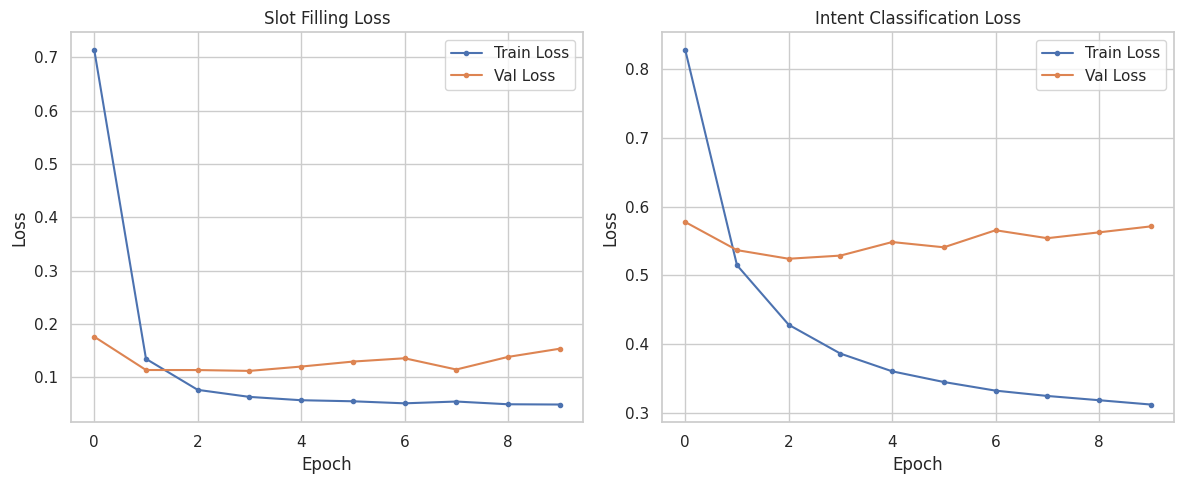


Generating Predictions...
Done. Best JSA: 0.8504


In [ ]:
# H. PLOTS & INFERENCE
# Plot Loss (Train vs Val) buat liat Overfitting
plt.figure(figsize=(12, 5))

# Plot 1: Slot Loss
plt.subplot(1, 2, 1)
plt.plot(tr_s_loss, label='Train Loss', marker='.')
plt.plot(val_s_loss, label='Val Loss', marker='.')
plt.title('Slot Filling Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

# Plot 2: Intent Loss
plt.subplot(1, 2, 2)
plt.plot(tr_i_loss, label='Train Loss', marker='.')
plt.plot(val_i_loss, label='Val Loss', marker='.')
plt.title('Intent Classification Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# Inference Code (Tetap sama)
if os.path.exists(test_csv):
    print("\nGenerating Predictions...")
    test_ds = CondaCsvDataset(test_csv, has_labels=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)

    model.load_state_dict(torch.load(os.path.join(save_dir, 'best.pt')))
    model.eval()

    lines = []
    with torch.no_grad():
        for x, lens, mask, _, _ in test_loader:
            s_logits, i_logits = model(x, lens, mask)
            ip = i_logits.argmax(-1).tolist()
            sp = s_logits.argmax(-1).tolist()
            for i, L in enumerate(lens.tolist()):
                intent = intent_map.itos[ip[i]]
                slots = [slot_map.itos[j] for j in sp[i][:L] if j < len(slot_map.itos)]
                lines.append(f"{intent} {' '.join(slots)}")

    with open(os.path.join(save_dir, 'answer_test.txt'), 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))
    print(f"Done. Best JSA: {best_jsa:.4f}")